In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import os
from PIL import Image, UnidentifiedImageError
import shutil

# Configuration
IMG_SIZE = (96, 96)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.4
SEED = 42
ROOT_PATH = ''
DATASET_PATH = os.path.join(ROOT_PATH,"raw_data")
CORRUPT_PATH = os.path.join(ROOT_PATH,"corrupt_images")
os.makedirs(CORRUPT_PATH, exist_ok=True)

for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".gif"]:
            path = os.path.join(root, file)
            try:
                with Image.open(path) as img:
                    img.verify()  # Check integrity
            except (UnidentifiedImageError, OSError, IOError) as e:
                # Move the corrupt image
                print(f"Corrupt image found: {path} — moving to {CORRUPT_PATH}")
                dest_path = os.path.join(CORRUPT_PATH, os.path.relpath(path, DATASET_PATH))
                os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                shutil.move(path, dest_path)

LANDMARK_DIR = os.path.join(ROOT_PATH,"data")
RAW_IMAGE_DIR = os.path.join(ROOT_PATH,"raw_data")
FILTERED_IMAGE_DIR = os.path.join(ROOT_PATH,"filtered_raw_data")
DATASET_PATH = FILTERED_IMAGE_DIR
# Supported image extensions
IMAGE_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.bmp']

# Create filtered output structure
os.makedirs(FILTERED_IMAGE_DIR, exist_ok=True)

for class_name in os.listdir(LANDMARK_DIR):
    if class_name == 'debug':
        continue
    landmark_class_dir = os.path.join(LANDMARK_DIR, class_name)
    raw_class_dir = os.path.join(RAW_IMAGE_DIR, class_name)
    filtered_class_dir = os.path.join(FILTERED_IMAGE_DIR, class_name)
    os.makedirs(filtered_class_dir, exist_ok=True)

    for file in os.listdir(landmark_class_dir):
        if not file.endswith("_landmarks.json"):
            continue

        # Get base filename without "_landmarks.json"
        base_name = file.replace("_landmarks.json", "")

        # Look for corresponding image in raw directory
        for ext in IMAGE_EXTENSIONS:
            image_file = os.path.join(raw_class_dir, base_name + ext)
            if os.path.exists(image_file):
                # Copy to filtered folder
                shutil.copy(image_file, os.path.join(filtered_class_dir, os.path.basename(image_file)))
                break

# Load training dataset with validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    color_mode="rgb",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
num_classes = len(train_ds.class_names)
label_map = train_ds.class_names

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    color_mode="rgb",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = val_ds.shard(2,0)
val_ds = val_ds.shard(2,1)
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
# Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 3488 files belonging to 26 classes.
Using 2093 files for training.
Found 3488 files belonging to 26 classes.
Using 1395 files for validation.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [3]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.0594 - loss: 3.6202 - val_accuracy: 0.1650 - val_loss: 2.9301
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.1798 - loss: 2.8242 - val_accuracy: 0.2547 - val_loss: 2.4942
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.2942 - loss: 2.3955 - val_accuracy: 0.3357 - val_loss: 2.1721
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.3880 - loss: 2.0473 - val_accuracy: 0.3835 - val_loss: 1.9820
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.4759 - loss: 1.7452 - val_accuracy: 0.3994 - val_loss: 1.9093
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5066 - loss: 1.5541 - val_accuracy: 0.4197 - val_loss: 1.8164
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.5838 - loss: 1.3988 - val_accuracy: 0.4327 - val_loss: 1.7915
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5724 - loss: 1.3272 - val_accuracy: 0.4573 -

In [4]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step - accuracy: 0.4467 - loss: 2.2660
Test Accuracy: 0.4702
Test Loss: 2.2137


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

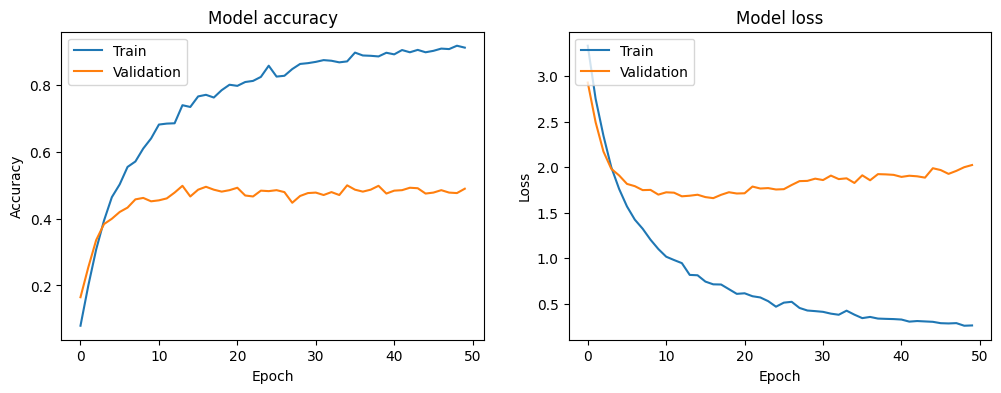

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

              precision    recall  f1-score   support

           A      0.923     0.632     0.750        19
           B      0.567     0.586     0.576        29
           C      0.250     0.333     0.286        27
           D      0.138     0.200     0.163        20
           E      0.577     0.600     0.588        25
           F      0.500     0.241     0.326        29
           G      0.690     0.690     0.690        29
           H      0.682     0.556     0.612        27
           I      0.429     0.375     0.400        24
           J      0.415     0.586     0.486        29
           K      0.421     0.286     0.340        28
           L      0.815     0.880     0.846        25
           M      0.375     0.158     0.222        38
           N      0.327     0.621     0.429        29
           O      0.619     0.448     0.520        29
           P      0.192     0.238     0.213        21
           Q      0.417     0.161     0.233        31
           R      0.414    

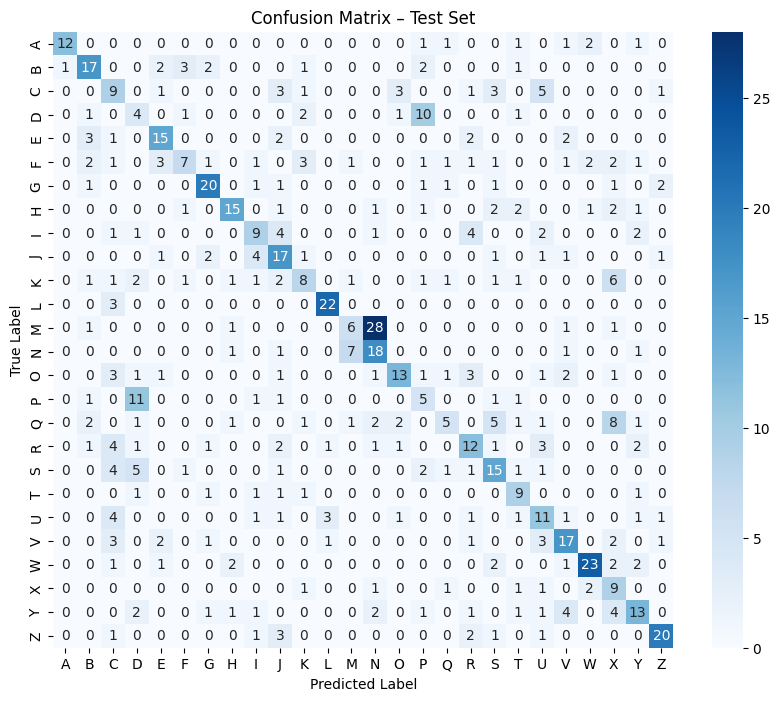

In [7]:
y_true, y_pred = [], []
target_names = [label_map[i] for i in range(len(label_map))]
for X_batch, y_batch in test_ds:
    y_true.append(y_batch.numpy())

    batch_pred = model.predict(X_batch, verbose=0)
    y_pred.append(np.argmax(batch_pred, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print(classification_report(
    y_true, y_pred,
    digits=3,                            
    target_names=target_names 
))

cm = confusion_matrix(y_true, y_pred, labels=range(len(label_map)))
labels = [label_map[i] for i in range(len(label_map))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Test Set")
plt.show()